In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


In [9]:
df = pd.read_csv('data/lyrics_data.csv', index_col=0)


In [10]:
# function to extract list of song sections
def get_sections(lyrics):
    # find all section headers enclosed in brackets
    headers = re.findall(r'\[.*?\]', lyrics)
    # extract values before colon
    sections = [re.findall(r'\[([^:]+)', header)[0] for header in headers]
    # remove non-letter characters and create list of unique values
    sections = [re.sub(r'[^a-zA-Z\s]', '', section) for section in sections]
    sections = [word for section in sections for word in section.split()]
    sections = list(set(sections))
    return sections

In [11]:
# function to remove headers, footers, and extra spaces
def clean_text(lyrics):
    lyrics = re.sub(r'^.*?Lyrics', '', lyrics)
    lyrics = re.sub(r'\d*Embed\b', '', lyrics)
    lyrics = re.sub(r'\s+', ' ', lyrics)
    lyrics = re.sub(r'\n\s*\n', '\n', lyrics)
    return lyrics

In [12]:
custom_sw = ["i'd", "i'm",
             'yeah', 'ah', 'oh']

sw = set(stopwords.words('english'))
sw.update(custom_sw)

In [13]:
# function to clean lyric text

def preprocess_lyrics(lyrics):
    
    # remove text before section header
    lyrics = re.sub(r'\[.*?\]', '', lyrics)

    # remove section headers inside brackets
    lyrics = re.sub(r'\[.*?\]', '', lyrics)

    # replace new line with space
    lyrics = lyrics.replace('\n', ' ')

    # remove numbers and special characters
    lyrics = re.sub(r'[^a-zA-Z\s]', '', lyrics)

    # replace dashes with space
    #lyrics = lyrics.replace('-', ' ')

    # lowercase all - or analyze based on capitalization such as names, cities, etc.
    lyrics = lyrics.lower()

    # remove stopwords - set custom list or don't remove
    lyrics = ' '.join([word for word in lyrics.split() if word not in sw])

    return lyrics


In [14]:
# extract song sections and apply basic text cleaning
df['sections'] = df['lyrics'].apply(get_sections)
df['lyrics'] = df['lyrics'].apply(clean_text)

In [15]:
df['lyrics_text'] = df['lyrics'].apply(preprocess_lyrics)
df

,genre,id,track,artist,album,release_date,release_year,length_ms,explicit,popularity,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,lyrics,sections,lyrics_text
0,pop,1V6gIisPpYqgFeWbMLI0bA,Heart Attack,['Demi Lovato'],Demi,2013-01-01,2013,210840,False,85,...,1,0.1040,0.0738,0.000000,0.2390,0.502,173.968,[Intro] Puttin' my defenses up 'Cause I don't ...,"[Chorus, PreChorus, Verse, Intro, Bridge]",puttin defenses cause dont wanna fall love eve...
1,pop,0K6iKgHPPhAb4Acmg9aD77,On My Love,"['Zara Larsson', 'David Guetta']",On My Love (Sped Up),2023-09-12,2023,222911,False,76,...,0,0.0460,0.0724,0.002900,0.0881,0.316,123.069,[Intro] (That's on my love) (That's on my love...,"[Chorus, PreChorus, Verse, Intro, Drop]",thats love thats love dont need time make mind...
2,pop,4e4fqjx0Izh4svvTef1z7e,Meant to Be (feat. Florida Georgia Line),"['Bebe Rexha', 'Florida Georgia Line']",Expectations,2018-06-22,2018,164205,False,77,...,1,0.0848,0.0476,0.000000,0.0646,0.589,153.995,January:Albums:Weezer (Teal Album) Bring Me th...,"[Cardi, Ray, Edition, feat, Chainz, Deluxe, Bi...",januaryalbumsweezer teal album bring horizon a...
3,pop,0HPD5WQqrq7wPWR7P7Dw1i,TiK ToK,['Kesha'],Animal (Expanded Edition),2010-01-01,2010,199693,False,86,...,0,0.1420,0.0991,0.000000,0.2890,0.714,120.028,[Verse 1] Wake up in the morning feelin' like ...,"[Chorus, Break, PreChorus, Verse, Bridge]",wake morning feelin like p diddy hey girl grab...
4,pop,3zHq9ouUJQFQRf3cm1rRLu,"Love Me Like You Do - From ""Fifty Shades Of Grey""",['Ellie Goulding'],Delirium (Deluxe),2015-11-06,2015,252534,False,80,...,1,0.0484,0.2470,0.000000,0.1250,0.275,189.857,Song of the YearKendrick Lamar - Alright Taylo...,[],song yearkendrick lamar alright taylor swift b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,country,6olKv2HP3XgBpvVxAswowe,Bartender,['Lady A'],747,2014-09-30,2014,198266,False,66,...,0,0.0340,0.0198,0.000007,0.3270,0.654,101.011,[Verse 1] 8 o’clock on Friday night I’m still ...,"[Bridge, Chorus, Verse]",oclock friday night im still home girls keep b...
2433,country,0DAjiINHQTnPnnY939Qyhw,Let It Rain,"['David Nail', 'Sarah Buxton']",Let It Rain,2011-01-01,2011,222253,False,51,...,1,0.0405,0.3850,0.000001,0.2470,0.561,77.881,[Verse 1: David Nail] It's hard to find the pe...,"[Break, Instrumental, Chorus, Verse]",hard find perfect time say something know gonn...
2434,country,2oHW5EW14gL2VG4q0gRh6j,Fine Wine,['Runaway June'],"Smoke, Wine & Whiskey",2024-01-26,2024,164413,False,44,...,0,0.0395,0.5140,0.000000,0.1420,0.856,106.502,[Verse 1] I tried to get over him sober But I ...,"[Bridge, Chorus, Verse]",tried get sober didnt get far im gonna pour cl...
2435,country,6Ser4pIAKEoXok7eDJPRK7,The Devil I Know,['Ashley McBryde'],The Devil I Know,2023-09-08,2023,187880,False,57,...,1,0.0437,0.0861,0.000000,0.1100,0.607,168.184,[Verse 1] A little outside of Elizabethtown Th...,"[PreChorus, PostChorus, Chorus, Verse]",little outside elizabethtown theres little bar...


In [20]:
# drop rows that don't include song sections
song_sections = ['Intro','Chorus', 'Verse', 'Bridge', 'Break', 'Solo', 'Instrumental', 'Outro']
df = df[df['sections'].apply(lambda x: any(section in x for section in song_sections) if x else False)].copy()


In [21]:
df['tokens'] = df['lyrics_text'].apply(lambda x: word_tokenize(x))

# modeling

In [ ]:
# organize code in eda !!

In [48]:
def get_metrics(model, X, y,):
    genres = ['pop', 'hip_hop', 'rock', 'country']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_score = model.score(X_train, y_train)
    
    #store results
    data = confusion_matrix(y_test, y_pred)
    results = {genres[i] : data[i][i]/sum(data[i]) for i in range(0, len(data))}
    
    result_df = pd.DataFrame(results, index=[0])
    result_df['model'] = f'Model: {model}'
    result_df['train_accuracy'] = train_score
    result_df['test_accuracy'] = model.score(X_test, y_test)
    return result_df[['model', 'train_accuracy', 'test_accuracy'] + genres]

In [49]:
# def create_confusion_matrix(df, name, conf_mat):
#     plt.subplots(figsize=(3,3))
#     sns.heatmap(conf_mat, annot=True, fmt='d',
#                 xticklabels=set(df.Genre.values), yticklabels=set(df.Genre.values), square=True)
#     plt.title(name)
#     plt.ylabel('Actual')
#     plt.xlabel('Predicted')

In [29]:
# train test split
X = df['lyrics_text']
y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [30]:
y_train.value_counts(normalize=True)

rock       0.312268
pop        0.254647
country    0.244734
hip hop    0.188352
Name: genre, dtype: float64

In [31]:
pipe_cv_rfc = Pipeline([
    ('cv', CountVectorizer()),
    ('rfc', RandomForestClassifier())
])

pipe_cv_rfc.fit(X_train,y_train)

pipe_cv_rfc.score(X_train, y_train), pipe_cv_rfc.score(X_test,y_test)

(0.9888475836431226, 0.6311881188118812)

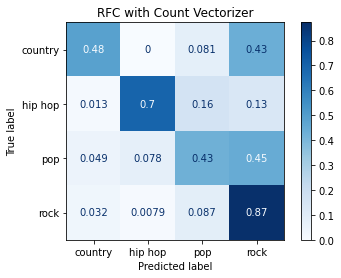

In [38]:
ConfusionMatrixDisplay.from_estimator(pipe_cv_rfc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("RFC with Count Vectorizer");

In [47]:
get_metrics("Random Forest with CountVectorizer", pipe_cv_rfc, X, y)

,model,train_accuracy,test_accuracy,pop,hip_hop,rock,country
0,Random Forest with CountVectorizer,0.988848,0.631188,0.484848,0.697368,0.427184,0.873016


In [39]:
pipe_tfv_rfc = Pipeline([
    ('tfv',TfidfVectorizer()),
    ('rfc', RandomForestClassifier())
])

pipe_tfv_rfc.fit(X_train,y_train)

pipe_tfv_rfc.score(X_train, y_train), pipe_tfv_rfc.score(X_test,y_test)

(0.9888475836431226, 0.655940594059406)

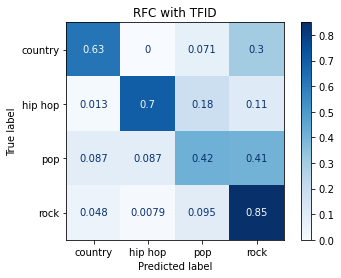

In [40]:
ConfusionMatrixDisplay.from_estimator(pipe_tfv_rfc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("RFC with TFID");

In [ ]:
word_counts = tfidf_df.sum()
word_counts.sort_values(ascending=False)

In [41]:
pipe_cv_dtc = Pipeline([
    ('cv',CountVectorizer()),
    ('dtc', DecisionTreeClassifier(random_state=42))]
)

pipe_cv_dtc.fit(X_train,y_train)

pipe_cv_dtc.score(X_train,y_train), pipe_cv_dtc.score(X_test,y_test)

(0.9888475836431226, 0.5222772277227723)

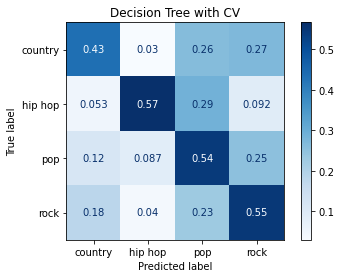

In [42]:
ConfusionMatrixDisplay.from_estimator(pipe_cv_dtc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("Decision Tree with CV");

In [43]:
pipe_tfid_dtc = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('dtc', DecisionTreeClassifier(random_state=42))]
)

pipe_tfid_dtc.fit(X_train,y_train)

pipe_tfid_dtc.score(X_train,y_train), pipe_tfid_dtc.score(X_test,y_test)

(0.9888475836431226, 0.49504950495049505)

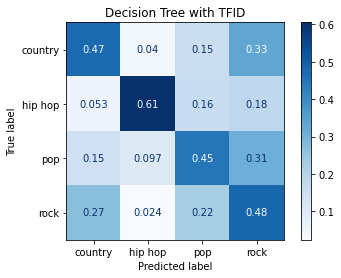

In [44]:
ConfusionMatrixDisplay.from_estimator(pipe_tfid_dtc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("Decision Tree with TFID");